In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
import kagglehub
path = kagglehub.dataset_download("nelgiriyewithana/emotions")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotions


In [36]:
df = pd.read_csv("/kaggle/input/emotions/text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [37]:
df['label'].unique()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


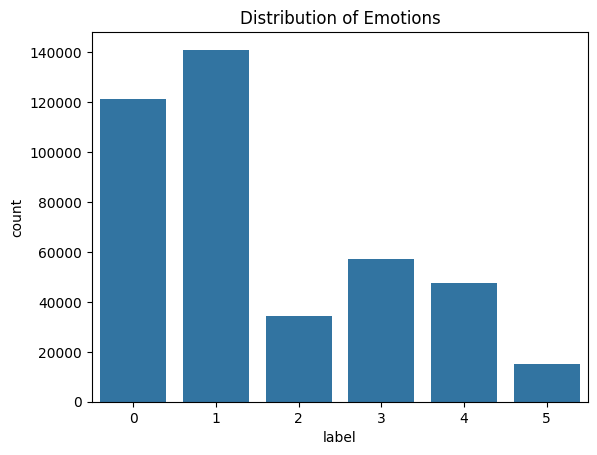

In [38]:
sns.countplot(x='label', data=df)
plt.title("Distribution of Emotions")
plt.show()

In [39]:
df = df.drop(columns=["Unnamed: 0"])

In [40]:
param_grid = {'alpha': [0.1, 0.5, 1.0]}
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(preprocess)

In [41]:
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [42]:
model = MultinomialNB()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

grid.fit(X_train_vectors, y_train)

y_pred = grid.predict(X_test_vectors)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%\n")


print("Best alpha:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

Accuracy: 88.70%

Best alpha: {'alpha': 0.1}
Best cross-validation accuracy: 0.886751711430945


In [43]:
emotion_labels = {
    0: "Sadness",
    1: "Joy",
    2: "Love",
    3: "Anger",
    4: "Fear",
    5: "Surprise"
}

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_labels.values()))

Classification Report:
              precision    recall  f1-score   support

     Sadness       0.90      0.97      0.93     36261
         Joy       0.85      0.97      0.91     42255
        Love       0.91      0.61      0.73     10241
       Anger       0.94      0.85      0.90     17295
        Fear       0.90      0.81      0.85     14394
    Surprise       0.86      0.50      0.63      4597

    accuracy                           0.89    125043
   macro avg       0.89      0.78      0.82    125043
weighted avg       0.89      0.89      0.88    125043



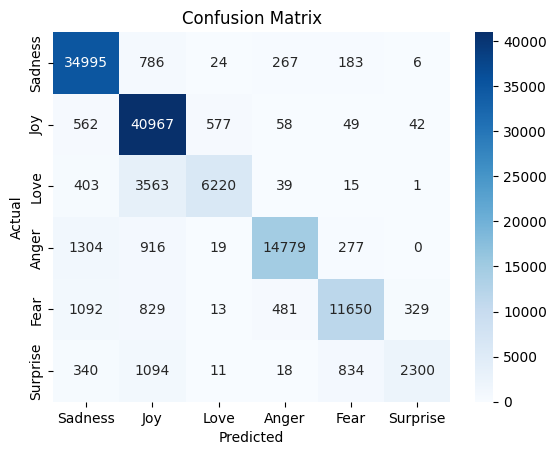

In [44]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()